[Applied Predictive Modeling](https://www.amazon.com/Applied-Predictive-Modeling-Max-Kuhn-ebook/dp/B00K15TZU0) states on page 61 that models can easily overemphasize patterns that are not reproducible.

This can happen for a multitude of reasons:
- temporary localized patterns
  - example: account from SC, shipping address in TX
- spurious correlations (examples from [tylervigen.com](https://www.tylervigen.com/spurious-correlations))

![spurious correlations](img/spurious_corelations.png)

- flukes in the data (example from the ODSC [Interpretability workshop](https://github.com/rajshah4/inter_workshop/blob/master/InterpretabilityWorkshop.pdf) by Rajiv Shah from DataRobot)

![the contributions of random features](img/random_variables.png)

In addition, page 295 of *[Introduction to Machine Learning with Python](https://www.amazon.com/Introduction-Machine-Learning-Python-Scientists/dp/1449369413)* points out that not all models provide a realistic representation of uncertainity. If overfit, a decision tree can be 100% certain of its predictions, even if it's almost never right.

We need a way to evaluate models to ensure quality, compare those models to determine which one is most appropriate, and at what threshold to set our final choice.

### The Confusion Matrix

Classification problems are generally evaluated using metrics derived from the confusion matrix.

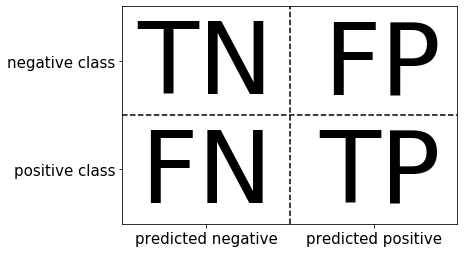

In [46]:
import mglearn
base_conf_mat = mglearn.plots.plot_binary_confusion_matrix()
plt.savefig('img/base_confusion_matrix.png')
base_conf_mat

The rows comprise the true values and the columns comprise the predicted values. These actual and predicted values combine to create four categories (counter clockwise): True Negative, False Negative, True Positive, and False Positive.

From the diagram you can see that the second word indicates the prediction (positive or negative) and the first word states whether that prediction was correct or incorrect (true or false).

A selection of metrics that can be derived from these four categories can be seen in this chart:

![Confusion Matrix](https://raw.githubusercontent.com/julielinx/datascience_diaries/master/img/metric_explanatory_chart.PNG)

Due to the imbalanced nature of our data, the metrics we're most interested in are recall (aka sensitivity), precision, and false positive rate (aka 1 - specificity). Using these three metrics we can examine recall vs precision and sensitivity vs specificity.

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, cross_val_predict
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import precision_recall_curve, auc, average_precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.datasets import load_digits, fetch_openml

In [48]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='recall')
    plt.xlabel('Threshold')
    plt.legend(loc='center right')
    plt.grid()
    plt.ylim([0, 1])
    
def plot_precision_vs_recall(precisions, recalls, thresholds):
    close_default = np.argmin(np.abs(thresholds - 0.5))
    plt.plot(precisions[close_default], recalls[close_default], 'o', markersize=10,
            label='threshold zero', fillstyle="none", c='k', mew=2)
    plt.plot(recalls, precisions, "b-", linewidth=2, label='precision recall curve')
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.legend(loc='best')
    plt.grid(True)
    
def plt_roc_curve(fpr, tpr, thresholds, label='ROC curve'):
    close_default = np.argmin(np.abs(thresholds - 0.5))
    plt.plot(fpr[close_default], tpr[close_default], 'o', markersize=10,
            label='default threshold 0.5', fillstyle="none", c='k', mew=2)
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

## MNIST data

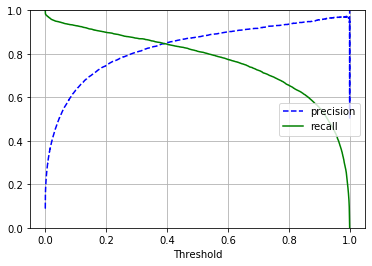

In [49]:
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data
y = mnist.target

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

y_train_5 = (y_train == '5').astype(int)
y_test_5 = (y_test == '5').astype(int)

pipe = make_pipeline(SimpleImputer(strategy='median'), StandardScaler(), LogisticRegression(max_iter=10000))
pipe.fit(X_train, y_train_5)

y_scores = cross_val_predict(pipe, X_train, y_train_5, cv=3, method='predict_proba')[:,1]

precisions, recalls, pr_thresholds = precision_recall_curve(y_train_5, y_scores)
mnist_pr_thresh = plot_precision_recall_vs_threshold(precisions, recalls, pr_thresholds)
plt.savefig('img/mnist_pr_thresh.png')
mnist_pr_thresh

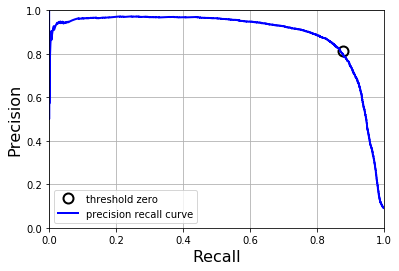

In [50]:
mnist_pr_curve = plot_precision_vs_recall(precisions, recalls, pr_thresholds)
plt.savefig('img/mnist_pr_curve.png')
mnist_pr_curve

In [51]:
print("Area under the PR curve:", auc(recalls, precisions))
print("Average percision:", average_precision_score(y_train_5, y_scores))

Area under the PR curve: 0.889513877990098
Average percision: 0.8896050927424619


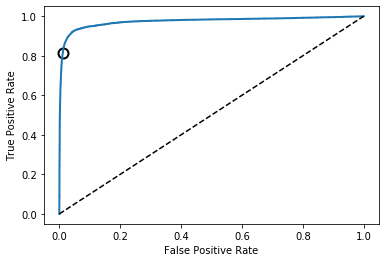

In [52]:
fpr, tpr, roc_thresholds = roc_curve(y_train_5, y_scores)
mnist_roc_curve = plt_roc_curve(fpr, tpr, roc_thresholds)
plt.savefig('img/mnist_roc_curve.png')
mnist_roc_curve

In [53]:
print("Area under the ROC curve:", roc_auc_score(y_train_5, y_scores))

Area under the ROC curve: 0.9736067962917803


## Horse Colic

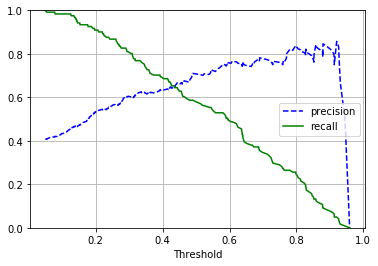

In [54]:
target = 'outcome'
names = ['surgery', 'age', 'hosp_num', 'rectal_temp', 'pulse', 'respiratory_rate', 'extremity_temp',
                  'peripheral_pulse', 'mucous_membranes', 'cap_refill_time', 'pain', 'peristalsis',
                  'ab_distension', 'nasogastric_tube', 'nasogastric_reflux', 'nasogastric_reflux_ph',
                  'rectal_exam', 'abdomen', 'packed_cell_vol', 'total_protein', 'abdominocentesis_app',
                  'abdomcentesis_total_protein', 'outcome', 'surgical_lesion',
                   'lesion_type', 'lesion2', 'lesion3', 'cp_data']
# cat_feats = ['surgery', 'age', 'mucous_membranes', 'cap_refill_time', 'pain', 'peristalsis',
#              'ab_distension', 'nasogastric_tube', 'nasogastric_reflux', 'rectal_exam',
#              'abdomen', 'abdominocentesis_app', 'surgical_lesion', 'lesion_type', 'cp_data']
num_feats = ['rectal_temp', 'pulse', 'respiratory_rate', 'extremity_temp', 'peripheral_pulse',
             'nasogastric_reflux_ph', 'packed_cell_vol', 'total_protein', 'abdomcentesis_total_protein']

raw_df = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/horse-colic/horse-colic.data",
            names=names, sep='\s', engine='python', na_values='?')
raw_df.drop(['lesion2','lesion3', 'hosp_num'], axis=1, inplace=True)

test_data = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/horse-colic/horse-colic.test",
            names=names, sep='\s', engine='python', na_values='?')
test_data.drop(['lesion2','lesion3', 'hosp_num'], axis=1, inplace=True)

raw_df.dropna(subset=['outcome'], inplace=True)
y_train = raw_df['outcome']
X_train = raw_df[num_feats]
y_test = test_data['outcome']
X_test = test_data[num_feats]

y_train = np.where(y_train>2, 2, y_train)
y_test = np.where(y_test>2, 2, y_test)

pipe = make_pipeline(SimpleImputer(strategy='median'), StandardScaler(), LogisticRegression())
pipe.fit(X_train, y_train)

y_scores = cross_val_predict(pipe, X_train, y_train, cv=10, method='predict_proba')[:,1]

precisions, recalls, pr_thresholds = precision_recall_curve(y_train, y_scores, pos_label=2)
colic_pr_thresh = plot_precision_recall_vs_threshold(precisions, recalls, pr_thresholds)
plt.savefig('img/colic_pr_thresh.png')
colic_pr_thresh

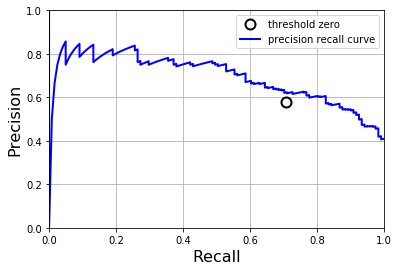

In [55]:
colic_pr_curve = plot_precision_vs_recall(precisions, recalls, pr_thresholds)
plt.savefig('img/colic_pr_curve.png')
colic_pr_curve

In [56]:
print("Area under the PR curve:", auc(recalls, precisions))
print("Average percision:", average_precision_score(y_train, y_scores))

Area under the PR curve: 0.6887544938462087
Average percision: 0.44135692702343804


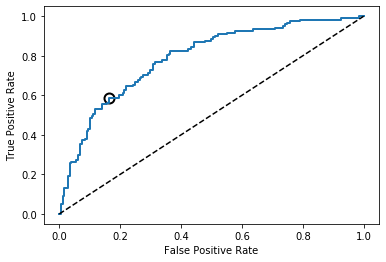

In [57]:
fpr, tpr, roc_thresholds = roc_curve(y_train, y_scores, pos_label=2)
colic_roc_curve = plt_roc_curve(fpr, tpr, roc_thresholds)
plt.savefig('img/colic_roc_curve.png')
colic_roc_curve

In [58]:
print("Area under the ROC curve:", roc_auc_score(y_train, y_scores))

Area under the ROC curve: 0.7886526139845854


## Titanic

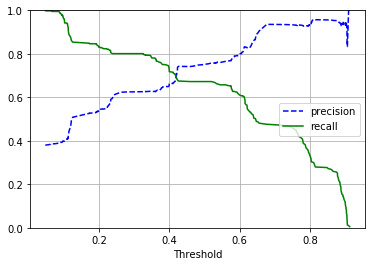

In [59]:
titanic = fetch_openml('titanic', version=1, as_frame=True)
df_raw = titanic.data
target = titanic.target

features = ['pclass', 'sex', 'sibsp', 'parch']
X = df_raw.loc[:, features]
X['sex'] = X['sex'].astype('category').cat.codes
y = target.copy().astype('category').cat.codes

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=12)
pipe = make_pipeline(SimpleImputer(strategy='median'), StandardScaler(), LogisticRegression())
pipe.fit(X_train, y_train)

y_scores = cross_val_predict(pipe, X_train, y_train, cv=10, method='predict_proba')[:,1]

precisions, recalls, pr_thresholds = precision_recall_curve(y_train, y_scores)
titanic_pr_thresh = plot_precision_recall_vs_threshold(precisions, recalls, pr_thresholds)
plt.savefig('img/titanic_pr_thresh.png')
titanic_pr_thresh

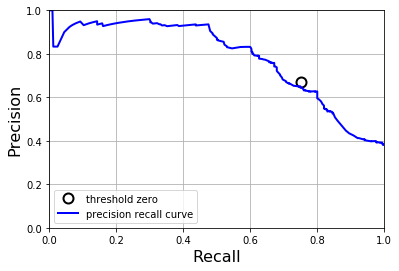

In [60]:
titanic_pr_curve = plot_precision_vs_recall(precisions, recalls, pr_thresholds)
plt.savefig('img/titanic_pr_curve.png')
titanic_pr_curve

In [61]:
print("Area under the PR curve:", auc(recalls, precisions))
print("Average percision:", average_precision_score(y_train, y_scores))

Area under the PR curve: 0.7822274422984722
Average percision: 0.7818285559523122


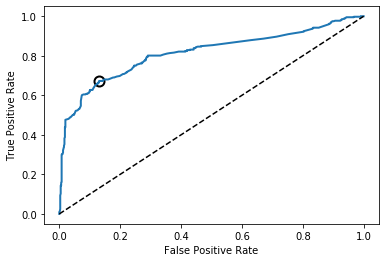

In [62]:
fpr, tpr, roc_thresholds = roc_curve(y_train, y_scores)
titanic_roc_curve = plt_roc_curve(fpr, tpr, roc_thresholds)
plt.savefig('img/titanic_roc_curve.png')
titanic_roc_curve

In [63]:
print("Area under the ROC curve:", roc_auc_score(y_train, y_scores))

Area under the ROC curve: 0.8138539042821158


In [64]:
plt.savefig('img/mnist_pr_thresh.png')
plt.savefig('img/mnist_pr_curve.png')
plt.savefig('img/mnist_roc_curve.png')

plt.savefig('img/colic_pr_thresh.png')
plt.savefig('img/colic_pr_curve.png')
plt.savefig('img/colic_roc_curve.png')

plt.savefig('img/titanic_pr_thresh.png')
plt.savefig('img/titanic_pr_curve.png')
plt.savefig('img/titanic_roc_curve.png')

<Figure size 432x288 with 0 Axes>